In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')
from matplotlib import cm
from log_progress import log_progress

In [84]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [140]:
%%cython -a --compile-args=-ffast-math --compile-args=-funroll-loops --compile-args=-ftree-loop-distribution --compile-args=-mtune=native
# distutils: language = c++

cimport cython
cimport numpy as np
import numpy as np
from numpy import linalg
from cpython cimport array
from libcpp.vector cimport vector

from libc.math cimport exp, pi, cos, sin
from libc.stdlib cimport rand, srand
cdef extern from "limits.h":
    int RAND_MAX

cdef class XYmodel:
    """Assume that J = 1"""
    cdef float T
    cdef int size
    cdef np.float64_t[:, :] lattice
    
    def __init__(self, int lattice_size, float T):
        self.T = T
        self.size = lattice_size
        self.lattice = self.random_init(lattice_size)
        srand(1)
    
    @property
    def lattice(self):
        return np.asarray(self.lattice)
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef random_init(self, int size):
        tmp = np.empty((size, size))
        cdef np.float64_t[:, :] array = tmp
        cdef int i, j
        for i in range(size):
            for j in range(size):
                # (-pi, pi)
                array[i][j] = pi * (2 * rand() / RAND_MAX - 1)
        return array
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision
    def step(self):
        cdef int x, y
        cdef np.float64_t random_spin
        cdef float delta_E
        cdef float boltz
        for i in range(self.size):
            for j in range(self.size):
                # choose random spin position
                x = (rand() % self.size)
                y = (rand() % self.size)
                
                # row major not column major, add some randomness (-pi/4, pi/4)
                random_spin = self.lattice[y][x] + 0.25 * pi * (2 * rand() / RAND_MAX - 1)
                
                # make sure random_spin is in range (-pi, pi)
                if random_spin >= pi:
                    random_spin -= 2 * pi
                if random_spin < -pi:
                    random_spin += 2 * pi
                
                # calculate E_new - E
                delta_E = self._compute_E(x, y, spin=random_spin) - self._compute_E(x, y)
            
                # update spin 
                boltz = 0
                if self.T != 0:
                    boltz = exp(-delta_E / self.T)
    
                if delta_E > 0:
                    if rand() < boltz * RAND_MAX:
                        self.lattice[y][x] = random_spin
                else:
                    self.lattice[y][x] = random_spin        
    
    @cython.initializedcheck(False)
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef _compute_E(self, int x, int y, np.float64_t spin=-9.9):
        cdef float E = 0
        right_x, left_x, up_y, down_y = self._periodic_boundary(x, y)
        # -9.9 -> just random number instead of None
        if spin != -9.9:
            # E_new
            E = -(cos(spin - self.lattice[up_y][x]) + 
                cos(spin - self.lattice[down_y][x]) + 
                cos(spin - self.lattice[y][right_x]) + 
                cos(spin - self.lattice[y][left_x]))
        else:
            # E_old
            E = -(cos(self.lattice[y][x] - self.lattice[up_y][x]) + 
                cos(self.lattice[y][x] - self.lattice[down_y][x]) + 
                cos(self.lattice[y][x] - self.lattice[y][right_x]) + 
                cos(self.lattice[y][x] - self.lattice[y][left_x]))
        return E
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef _periodic_boundary(self, int x, int y):
        # periodic boundary condition
        cdef int right_x = x + 1;
        cdef int left_x = x - 1;
        cdef int up_y = y - 1
        cdef int down_y = y + 1  
        if left_x < 0:
            left_x = self.size - 1
        if right_x > self.size - 1:
            right_x = 0
        if up_y < 0:
            up_y = self.size - 1
        if down_y > self.size - 1:
            down_y = 0
        return right_x, left_x, up_y, down_y
    
    def calculate_M(self):
        """
        Calculate magnetization per spin
        """
        M_x = np.sum(np.cos(np.asarray(-1) * self.lattice))
        M_y = np.sum(np.sin(np.asarray(-1) * self.lattice))
        M = np.array([M_x, M_y])
        M = linalg.norm(M) / (self.size ** 2)
        return M
    
    def calculate_Sus(self):
        """
        Calculate magnetic susceptibility per spin
        """
        # TODO: 
        # Sth wrong...
        M_x = np.sum(np.power(np.cos(np.asarray(-1) * self.lattice), 2))
        M_y = np.sum(np.power(np.sin(np.asarray(-1) * self.lattice), 2))
        M2 = np.array([M_x, M_y])
        M2 = linalg.norm(M2) / (self.size ** 2)
        Sus = (1 / self.T) * (M2 - self.calculate_M() ** 2)
        return Sus / (self.size ** 2)
    
    def calculate_Helicity(self):
        # https://arxiv.org/pdf/cond-mat/0304226.pdf
        # https://arxiv.org/pdf/1210.6116.pdf
        # https://arxiv.org/pdf/cond-mat/0502556.pdf
        # https://edoc.hu-berlin.de/bitstream/handle/18452/14664/Korzec.pdf?sequence=1
        """
        Calculate helicity modulus per spin
        Y = < E (per spin) > - size^2 / T * < s^2 >
        """
        # TODO: s is very slow -> as the result I get only energy!
        s = 0
        for j in range(self.size):
            for i in range(self.size):
                s += (np.sin(self.lattice[i][j]-self.lattice[(i - 1) % self.size][j])+
                      np.sin(self.lattice[i][j]-self.lattice[(i + 1) % self.size][j])+
                      np.sin(self.lattice[i][j]-self.lattice[i][(j - 1) % self.size])+
                      np.sin(self.lattice[i][j]-self.lattice[i][(j + 1) % self.size]))
        s = s / (self.size ** 2)
        Y = self.calculate_E() - (self.size ** 2) / self.T * s
        return Y
    
    def calculate_E(self):
        """
        Calculate energy per spin
        """
        E = 0
        for j in range(self.size):
            for i in range(self.size):
                E -= (np.cos(self.lattice[i][j]-self.lattice[(i - 1) % self.size][j])+
                      np.cos(self.lattice[i][j]-self.lattice[(i + 1) % self.size][j])+
                      np.cos(self.lattice[i][j]-self.lattice[i][(j - 1) % self.size])+
                      np.cos(self.lattice[i][j]-self.lattice[i][(j + 1) % self.size]))
        return E * 0.5 / (self.size ** 2)
    
    
    
# Calculate Energy and Magnetization
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision
def get_Energy_Mag(int L, float min_T=0.1, float max_T=2.5, int step_T=25, int ESTEP=1000, int STEP=2000):
    """L - lattice size"""
    cdef vector[float] energy
    cdef vector[float] magnet
    cdef vector[float] T_range
    cdef XYmodel xy = None
    energy.reserve(step_T)
    magnet.reserve(step_T)
    T_range.reserve(step_T)
    
    cdef float E
    cdef float M
    cdef int step
    cdef float by_T = (max_T - min_T) / step_T
    for step in range(step_T):
        T_range.push_back(by_T + step * by_T) 
        
    cdef float T
    for T in T_range:
        xy = XYmodel(lattice_size=L, T=T)
        E = 0
        M = 0
        # get the thermal equilibrium
        for _ in range(ESTEP):
            xy.step()
        for _ in range(STEP):
            xy.step()
            E += xy.calculate_E()
            M += xy.calculate_M()
        
        energy.push_back(E / STEP)
        magnet.push_back(M / STEP)
    
    E_list = []
    M_list = []
    for i in range(step_T):
        E_list.append(energy[i])
        M_list.append(magnet[i])
    
    return E_list, M_list

In [128]:
L = 20 # lattice size
xy = XYmodel(L, T=0.8)
for _ in range(5000):
    xy.step()

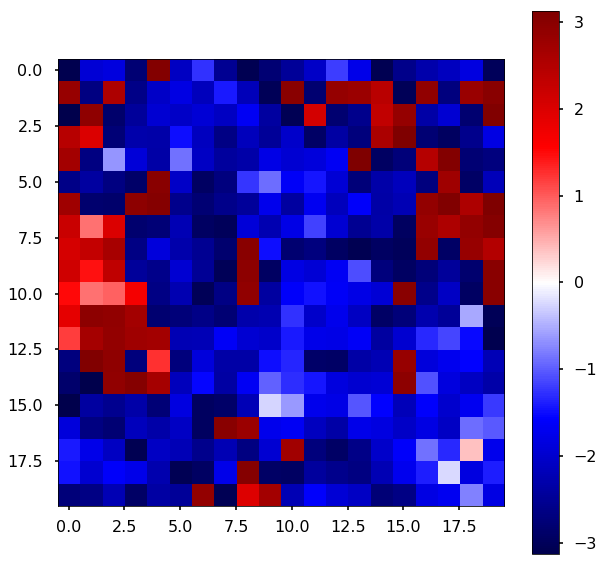

In [129]:
plt.figure(figsize=(10,10))
plt.imshow(xy.lattice, cmap=cm.seismic)
plt.colorbar()
plt.show()

# Calculate Energy and Magnetization

In [142]:
E_8, M_8 = get_Energy_Mag(8)

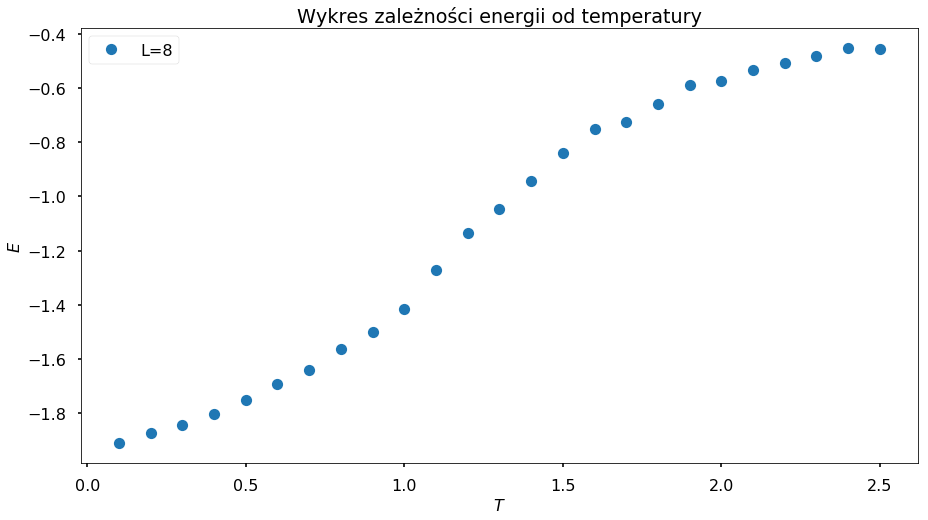

In [143]:
min_T = 0.1
max_T = 2.5
step_T = 25
T_range = np.linspace(min_T, max_T, step_T)

plt.figure(figsize=(15, 8))
plt.plot(T_range, E_8, 'o', label='L=8')
# plt.plot(T_range, E_16, 'o', label='L=16')
# plt.plot(T_range, E_32, 'o', label='L=32')
# plt.plot(T_range, E_64, 'o', label='L=64')

plt.xlabel("$T$", fontsize=16)
plt.ylabel("$E$", fontsize=16)
plt.title("Wykres zależności energii od temperatury")
plt.legend(loc='upper left')
# plt.savefig("Energia.svg", dpi=800, bbox_inches='tight', format="svg")
plt.show()

# TODO

**optimize calculation**
- [ ] Energy
- [ ] Magnetization
- [ ] Plot E(T) and M(T) on Lattice size 8 16 32 64 128